In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, RenyiELBO
from pyro.infer import MCMC, NUTS
from pyro import poutine
import pyro.distributions as dist
from pyro.infer.util import (
    torch_item,
)
from pyro.util import check_if_enumerated, warn_if_nan

import pyro.poutine as poutine

In [2]:
def mixture_model(mu,sigma):
    mu2 = mu + 3
    sig2 = sigma * 2
    
    mixture = 0.5 * pyro.sample("n1", dist.Normal(mu, sigma)) +  0.5 * pyro.sample("n2", dist.Normal(mu2, sig2))
# try with very wide + peaked distributions

In [3]:
# auto noraml multivarite
def guide(mu, sigma):
    # mu very sensitive to prior???
    mu1 = pyro.param("mu1", torch.tensor(0),
                         constraint=constraints.positive)
    sig1 = pyro.param("sig1", torch.tensor(1),
                        constraint=constraints.positive)
    mu2 = pyro.param("mu2", torch.tensor(0),
                         constraint=constraints.positive)
    sig2 = pyro.param("sig2", torch.tensor(1),
                        constraint=constraints.positive)
    mixture = 0.5 * pyro.sample("n1", dist.Normal(mu1, sig1)) +  0.5 * pyro.sample("n2", dist.Normal(mu2, sig2))
    return mixture

In [4]:
def mle_loss(mu1_y, sig1_y, mu2_y, sig2_y):
    # grab the learned variational parameters
    mu1 = pyro.param("mu1").item()
    sig1 = pyro.param("sig1").item()
    mu2 = pyro.param("mu2").item()
    sig2 = pyro.param("sig2").item()
    
    return (mu1 - mu1_y) ** 2 + (sig1 - sig1_y) ** 2 + (mu2 - mu2_y) ** 2 + (sig2 - sig2_y) ** 2

In [5]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 2000

assert pyro.__version__.startswith('1.8.6')

# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [6]:
alpha = 0.99

# setup the optimizer
adam_params = {"lr": 0.0005}
optimizer = Adam(adam_params)
n_models = 3
# setup the inference algorithm
# svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
models = []
for n in range(n_models):
    models.append(SVI(mixture_model, guide, optimizer, loss=RenyiELBO(alpha)))


CPU times: total: 26.9 s
Wall time: 28.5 s


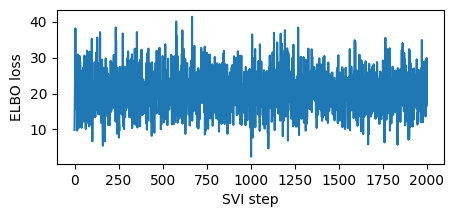

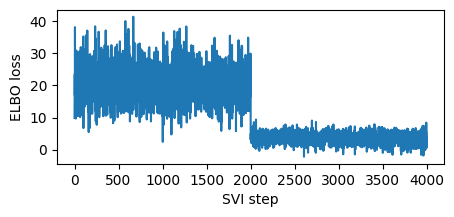

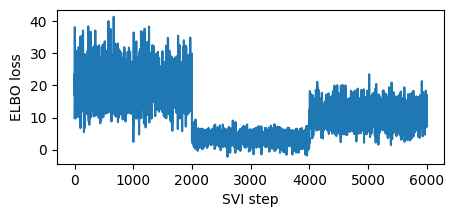

In [7]:
%%time
# These should be reset each training loop.
losses = []
lr = 0.01

y = []
estimations = []
for m in models:
    pyro.clear_param_store()
    # train specific model on task
    mu = pyro.sample("mu1", dist.Uniform(0,3))
    sig = pyro.sample("sig1", dist.Uniform(0.5,1.0))
    y.append((mu,sig, mu+3, sig*2))
    for step in range(n_steps):
        loss = m.step(mu, sig)
        losses.append(loss)
#         if step%1000 == 0:
#             print(step) 
            
    # compute meta loss over all tasks with respect to alpha
    meta_loss = mle_loss(mu, sig, mu+3, sig*2)
    # update alpha
    alpha -=  lr * (1/len(models)) * meta_loss
    m.loss=RenyiELBO(alpha)
#     print(meta_loss, m.loss.alpha)
    
    mu1 = pyro.param("mu1").item()
    sig1 = pyro.param("sig1").item()
    mu2 = pyro.param("mu2").item()
    sig2 = pyro.param("sig2").item()
    
    estimations.append((mu1,sig1,mu2,sig2))
    
    plt.figure(figsize=(5, 2))
    plt.plot(losses)
    plt.xlabel("SVI step")
    plt.ylabel("ELBO loss");

In [8]:
# grab the learned variational parameters
y,  estimations

([(tensor(2.6030), tensor(0.5997), tensor(5.6030), tensor(1.1994)),
  (tensor(0.7378), tensor(0.7568), tensor(3.7378), tensor(1.5136)),
  (tensor(2.4564), tensor(0.7849), tensor(5.4564), tensor(1.5697))],
 [(0.0, 0.8362932205200195, 0.0, 1.0936708450317383),
  (0.0, 0.8117471933364868, 0.0, 1.3331422805786133),
  (0.0, 0.8857540488243103, 0.0, 1.3547590970993042)])